# Deep Learning
## Assignment 3
Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in notmist.ipynb.

In [7]:
pickle_file = 'notMNIST_sanitized.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['sanitized_train_dataset']
  train_labels = save['sanitized_train_labels']
  valid_dataset = save['sanitized_valid_dataset']
  valid_labels = save['sanitized_valid_labels']
  test_dataset = save['sanitized_test_dataset']
  test_labels = save['sanitized_test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (187217, 28, 28) (187217,)
Validation set (8933, 28, 28) (8933,)
Test set (8676, 28, 28) (8676,)


Reformat into a shape that's more adapted to the models we're going to train:
* data as a flat matrix,
* labels as float 1-hot encodings.

In [8]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (187217, 784) (187217, 10)
Validation set (8933, 784) (8933, 10)
Test set (8676, 784) (8676, 10)


In [9]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

## Problem 1 (I have made only Neural Net)
### Step 1 - Find regularization parameter using validation set
Use the value of regularization parameter which gives least loss (I have used error instead of loss) i.e which gives least error (100-accuracy)

In [33]:
batch_size = 128
H = 1024 # No. of hidden units

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  # Training set
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  # Validation set
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  # Test set
  tf_test_dataset = tf.constant(test_dataset)
  # Regularization parameter - beta 
  tf_beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, H]))
  biases1 = tf.Variable(tf.zeros([H]))
  weights2 = tf.Variable(
    tf.truncated_normal([H, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  train_hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  train_logits = tf.matmul(train_hidden1, weights2) + biases2
  # Regularization term  
  regularizer = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2)
  # Training loss
  train_loss = tf.nn.softmax_cross_entropy_with_logits(train_logits, tf_train_labels)
  train_l2_loss = tf.reduce_mean(train_loss + tf_beta*regularizer)
    
  # Validation computation.
  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_logits = tf.matmul(valid_hidden1, weights2) + biases2
  # Validation loss
  valid_loss = tf.nn.softmax_cross_entropy_with_logits(valid_logits, tf_valid_labels)
  valid_l2_loss = tf.reduce_mean(valid_loss + tf_beta*regularizer)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(train_l2_loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(train_logits)
  valid_prediction = tf.nn.softmax(valid_logits)
  test_prediction = tf.nn.softmax(tf.matmul(
                                   tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

In [123]:
num_steps = 3001 

beta_values = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
train_error = np.array([0.0]*len(beta_values))
valid_error = np.array([0.0]*len(beta_values))

for i, beta in enumerate(beta_values):
    print('Beta -------------------->', beta)
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss of training set at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%\n" % accuracy(
                valid_prediction.eval(), valid_labels))
                # Final step for SGD optimizer (minibatch)
                if step == num_steps-1:
                    train_error[i] = 100 - accuracy(predictions, batch_labels)
                    valid_error[i] = 100 - accuracy(valid_prediction.eval(), valid_labels)
        print("Minibatch error for validation set: %.1f%%" % (100 - accuracy(valid_prediction.eval(), valid_labels)))

Beta --------------------> 0.0001
Initialized
Minibatch loss of training set at step 0: 376.099091
Minibatch accuracy: 14.1%
Validation accuracy: 39.0%

Minibatch loss of training set at step 500: 47.652878
Minibatch accuracy: 78.1%
Validation accuracy: 77.9%

Minibatch loss of training set at step 1000: 35.493580
Minibatch accuracy: 81.2%
Validation accuracy: 80.0%

Minibatch loss of training set at step 1500: 28.988743
Minibatch accuracy: 86.7%
Validation accuracy: 80.2%

Minibatch loss of training set at step 2000: 29.919542
Minibatch accuracy: 82.0%
Validation accuracy: 79.5%

Minibatch loss of training set at step 2500: 25.305779
Minibatch accuracy: 84.4%
Validation accuracy: 78.9%

Minibatch loss of training set at step 3000: 27.613459
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%

Minibatch error for validation set: 18.7%
Test accuracy: 88.3%


Beta --------------------> 0.0003
Initialized
Minibatch loss of training set at step 0: 411.444275
Minibatch accuracy: 9.4%
Valid

Plot curves to visualize effect of learning rate on error

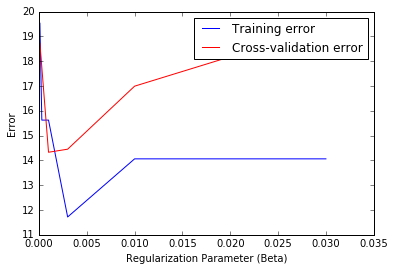

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(beta_values, train_error, 'b', label='Training error')
plt.plot(beta_values, valid_error, 'r', label='Cross-validation error')
plt.xlabel('Regularization Parameter (Beta)')
plt.ylabel('Error')
plt.legend()
plt.show()

# Regularization parameter - beta value of 0.001 gives 
# least error which is evident in the graph
beta = 0.001

Train the model and use l2 regularization using beta=0.001

In [14]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
        _, l, predictions = session.run(
             [optimizer, train_l2_loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss of training set at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%\n" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss of training set at step 0: 693.505371
Minibatch accuracy: 6.2%
Validation accuracy: 34.4%

Minibatch loss of training set at step 500: 202.500427
Minibatch accuracy: 75.8%
Validation accuracy: 77.9%

Minibatch loss of training set at step 1000: 114.688881
Minibatch accuracy: 85.9%
Validation accuracy: 80.9%

Minibatch loss of training set at step 1500: 68.719307
Minibatch accuracy: 85.2%
Validation accuracy: 81.9%

Minibatch loss of training set at step 2000: 41.761688
Minibatch accuracy: 83.6%
Validation accuracy: 82.0%

Minibatch loss of training set at step 2500: 25.414898
Minibatch accuracy: 83.6%
Validation accuracy: 83.7%

Minibatch loss of training set at step 3000: 15.433825
Minibatch accuracy: 87.5%
Validation accuracy: 85.3%

Test accuracy: 92.1%


## Problem 1
### Step skipped: Plot learning curves to obeserve trade-off between bias and variance

## Problem 2
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

In [34]:
num_steps = 5 # Fewer batches

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
        _, l, predictions = session.run(
             [optimizer, train_l2_loss, train_prediction], feed_dict=feed_dict)
        if (step % 20 == 0):
            print("Minibatch loss of training set at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%\n" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss of training set at step 0: 655.321777
Minibatch accuracy: 8.6%
Validation accuracy: 37.0%

Test accuracy: 47.8%


## Problem 3
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.
What happens to our extreme overfitting case?

In [37]:
batch_size = 128
H = 1024 # No. of hidden units

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  # Training set
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  # Validation set
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_valid_labels = tf.constant(valid_labels)
  # Test set
  tf_test_dataset = tf.constant(test_dataset)
  # Regularization parameter - beta 
  tf_beta = tf.placeholder(tf.float32)
  # Keeping probability while dropping out units
  tf_dropout = 0.5
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, H]))
  biases1 = tf.Variable(tf.zeros([H]))
  weights2 = tf.Variable(
    tf.truncated_normal([H, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  train_hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  train_hidden1 = tf.nn.dropout(train_hidden1, tf_dropout)
  train_logits = tf.matmul(train_hidden1, weights2) + biases2
  # Regularization term  
  regularizer = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2)
  # Training loss
  train_loss = tf.nn.softmax_cross_entropy_with_logits(train_logits, tf_train_labels)
  train_l2_loss = tf.reduce_mean(train_loss + tf_beta*regularizer)
    
  # Validation computation.
  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_hidden1 = tf.nn.dropout(valid_hidden1, tf_dropout)
  valid_logits = tf.matmul(valid_hidden1, weights2) + biases2
  # Validation loss
  valid_loss = tf.nn.softmax_cross_entropy_with_logits(valid_logits, tf_valid_labels)
  valid_l2_loss = tf.reduce_mean(valid_loss + tf_beta*regularizer)
    
  # Test computation.
  test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_hidden1 = tf.nn.dropout(test_hidden1, tf_dropout)
  test_logits = tf.matmul(test_hidden1, weights2) + biases2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(train_l2_loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(train_logits)
  valid_prediction = tf.nn.softmax(valid_logits)
  test_prediction = tf.nn.softmax(test_logits)

In [38]:
num_steps = 10 # Fewer batches

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
        _, l, predictions = session.run(
             [optimizer, train_l2_loss, train_prediction], feed_dict=feed_dict)
        if (step % 20 == 0):
            print("Minibatch loss of training set at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%\n" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss of training set at step 0: 788.085266
Minibatch accuracy: 10.2%
Validation accuracy: 22.4%

Test accuracy: 77.1%


### Obeservation
With 5 batches to train, test accuracy without dropout (regularization) 47.8% (See Problem 2 of this assignment)
The reason is overfitting. This is an extreme case of overfitting.
With dropout we get test accuracy of 77.1%. Adding dropout significantly increased the accuracy.

### Using Dropout
Regularization using dropout may not shine out for model which was trained on many batches. But if the model is deep enough (many hidden layers) and also wider (many activation units), dropout is a really nice option for regularization.

## Problem 4
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:
<br><code>
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
</code></br>

## I have divided Problem 4 into 2 notebooks: 
## 1 - DNN-2-Hidden-Layers
## 2 - DNN-3, 4-Hidden-Layers
## I got max accuracy of 96.1 % (but didn't record it by mistake) with 4 Hidden Layered network without tuning the hyper-parameters. I have max recorded accuracy of 95.8% with  3 Hidden Layered network. Would've gotten more if it wasn't for the lack of time